# Анализ астроцитов

Подключение библиотек

In [2]:
%matplotlib inline

In [3]:
import os
import sys
import ccdb
import napari

import matplotlib.pyplot as plt

from importlib import reload

from tqdm.auto import tqdm
from scipy import ndimage as ndi

In [4]:
from numpy.random import randint

In [5]:
# import hessian_cecp as hcecp
from imfun import fseq

Can't load imreg package, affine and homography registrations won't work


In [6]:
from astromorpho import io as aio
from astromorpho import enh, morpho

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/tifffile.py:7261: UserWarning: No module named 'imfun.external._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/czifile.py:146: UserWarning: ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/
  warnings.warn(
2022-06-24 15:21:36.968967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/levtg/astro-morpho/venv/lib/python3.10/site-packages/cv2/../../lib64:/home/levtg/v3d_external/v3d_main/common_lib/lib/
2022-06-24 15:21:36.968987: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dler

In [7]:
sys.path.append('/home/incredible/Neuroscience/lib')

# import elliptic_fourie as elfr

Настройка глобальных пременных для графиков

In [8]:
plt.rc('image', aspect='equal', interpolation='nearest',cmap='gray')
plt.rc('figure', figsize=(10,10))
plt.rc('axes', grid=True, labelsize=16)

In [9]:
def show_napari(img, name):
    return napari.view_image(img, name=name, ndisplay=3, rendering='attenuated_mip', gamma=1)

In [10]:
def add_napari(img, w, name):
    w.add_image(img, name=name, gamma=0.6, opacity=0.5)

Путь к изображениям

In [11]:
data_path = '/home/levtg/astro-morpho/data/'

In [12]:
names = !ls $data_path/*.pic
names = [name for name in names if not 'hm' in name or not 'red' in name]

Эта картинка не открывается автоматически, поэтому исключаем её

In [13]:
names.pop(names.index('/home/incredible/Neuroscience/Code/data/4wk-both5-red-raw.pic'))

ValueError: '/home/incredible/Neuroscience/Code/data/4wk-both5-red-raw.pic' is not in list

## Выбираем рандомную картинку

In [14]:
# k = randint(len(names))
# # k = 0
# k = names.index('/home/levtg/astro-morpho/data/3wk-both1-grn-raw.pic')
# print(k, names[k])
filename = '/home/levtg/astro-morpho/data/3wk-both1-grn-raw.pic'
stack, meta = ccdb.read_pic(filename)
# stack, meta = ccdb.read_pic('/home/incredible/Neuroscience/selected-for-complexity/data/1wk-both8-red-raw.pic')
dims = ccdb.get_axes(meta)#[::-1]
dims

[(0.06491228, "Microns'"), (0.06491228, "Microns'"), (0.3, "Microns'")]

In [15]:
if len(dims):
    zoom = dims[0][0]/dims[-1][0]
else:
    zoom = 4

In [16]:
1/zoom

4.621621671585099

In [17]:
stackz = ndi.zoom(stack.astype(float),(1, zoom,zoom))
stack.shape, stackz.shape

((77, 1024, 1024), (77, 222, 222))

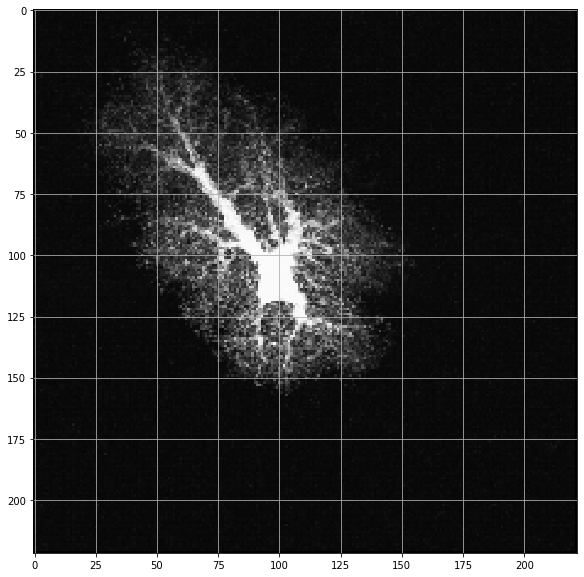

In [18]:
plt.imshow(stackz.max(0))

In [19]:
# w = napari.view_image(stackz, ndisplay=3, rendering='attenuated_mip', gamma=0.6)

### Threshold

In [20]:
import numpy as np

In [21]:
from skimage.filters import threshold_otsu, rank, threshold_yen, threshold_isodata, threshold_li, \
                            threshold_local, threshold_minimum, threshold_mean, threshold_niblack, \
                            threshold_sauvola, threshold_triangle#, threshold_adaptive
from skimage.morphology import disk
from skimage.filters import rank

from skimage.exposure import adjust_gamma
import cv2 as cv

In [22]:
def apply_thresh(image, thresh_func, shape, **kwargs):
    thresh = thresh_func(image, **kwargs)
    binary = full_img >= thresh
    filtered_image = np.where(binary, image, 0)
    return filtered_image.reshape(shape), thresh

In [23]:
thresh_image = enh.percentile_rescale(stackz)

In [24]:
gamma_image_06 = adjust_gamma(thresh_image, gamma=0.6)
gamma_image_1 = adjust_gamma(thresh_image, gamma=1)

In [25]:
w = show_napari(gamma_image_1, name='start_img_gamma_1')

In [26]:
IMG_SHAPE = thresh_image.shape

In [27]:
full_img_06 = gamma_image_06.reshape((IMG_SHAPE[0], -1))
full_img_06.shape

(77, 49284)

In [28]:
full_img = gamma_image_1.reshape((IMG_SHAPE[0], -1))
full_img.shape

(77, 49284)

#### Yen - Little

гамма = 0,6

In [29]:
yen_img, yen_thresh = apply_thresh(full_img, threshold_yen, IMG_SHAPE)

In [30]:
add_napari(yen_img, name='yen_img', w=w)

#### Isodata - More

гамма = 0,6

In [31]:
iso_img, iso_thresh = apply_thresh(full_img, threshold_isodata, IMG_SHAPE)

In [32]:
add_napari(iso_img, name='iso_img', w=w)

#### Li - Near Triangle

гамма = 1

In [33]:
li_img, li_thresh = apply_thresh(full_img, threshold_li, IMG_SHAPE)
# add_napari(li_img, name='li_img', w=w)

#### Local - Failed

гамма = 0.6

In [34]:
local_img, local_thresh = apply_thresh(full_img, threshold_local, IMG_SHAPE, block_size=3)
# add_napari(local_img, name='local_img', w=w)

#### Minimum - Failed

In [35]:
min_img, min_thresh = apply_thresh(full_img, threshold_minimum, IMG_SHAPE)
# add_napari(min_img, name='min_img', w=w)

#### Mean - Failed

гамма = 0,6

In [36]:
mean_img, mean_thresh = apply_thresh(full_img_06, threshold_mean, IMG_SHAPE)
# add_napari(mean_img, name='mean_img', w=w)

#### Niblack - Failed

гамма = 0.6

In [37]:
nib_img, nib_thresh = apply_thresh(full_img_06, threshold_niblack, IMG_SHAPE)
# add_napari(nib_img, name='nib_img', w=w)

#### Sauvola - Failed

гамма = 0.6

In [38]:
sauv_img, sauv_thresh = apply_thresh(full_img_06, threshold_sauvola, IMG_SHAPE)
# add_napari(sauv_img, name='sauv_img', w=w)

#### Triangle - Close to Li

гамма = 1

In [39]:
tri_img, tri_thresh = apply_thresh(full_img, threshold_triangle, IMG_SHAPE)
# add_napari(tri_img, name='tri_img', w=w)

#### Adaptive - need newer version

In [40]:
adapt_img, adapt_thresh = apply_thresh(full_img, threshold_adaptive, img.shape, block_size=3, sigma=1)
# add_napari(adapt_img, name='adapt_img', w=w)

NameError: name 'threshold_adaptive' is not defined

**DEBUG_MODE_ON**

In [ ]:
w = show_napari(clean_img, name='li')
add_napari(np.where(tri_img, stackz_sato, 0), name='tri', w=w)
add_napari(stackz_sato, name='original', w=w)

In [ ]:
np.save('original.npy', stackz_sato)
np.save('li_filter.npy', np.where(li_img, stackz_sato, 0))
np.save('tri_filter.npy', np.where(tri_img, stackz_sato, 0))

**DEBUG_MODE_OFF**


 

In [41]:
correction_image = adjust_gamma(thresh_image, gamma=0.2).max(0)

In [42]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors = ["black", "red"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

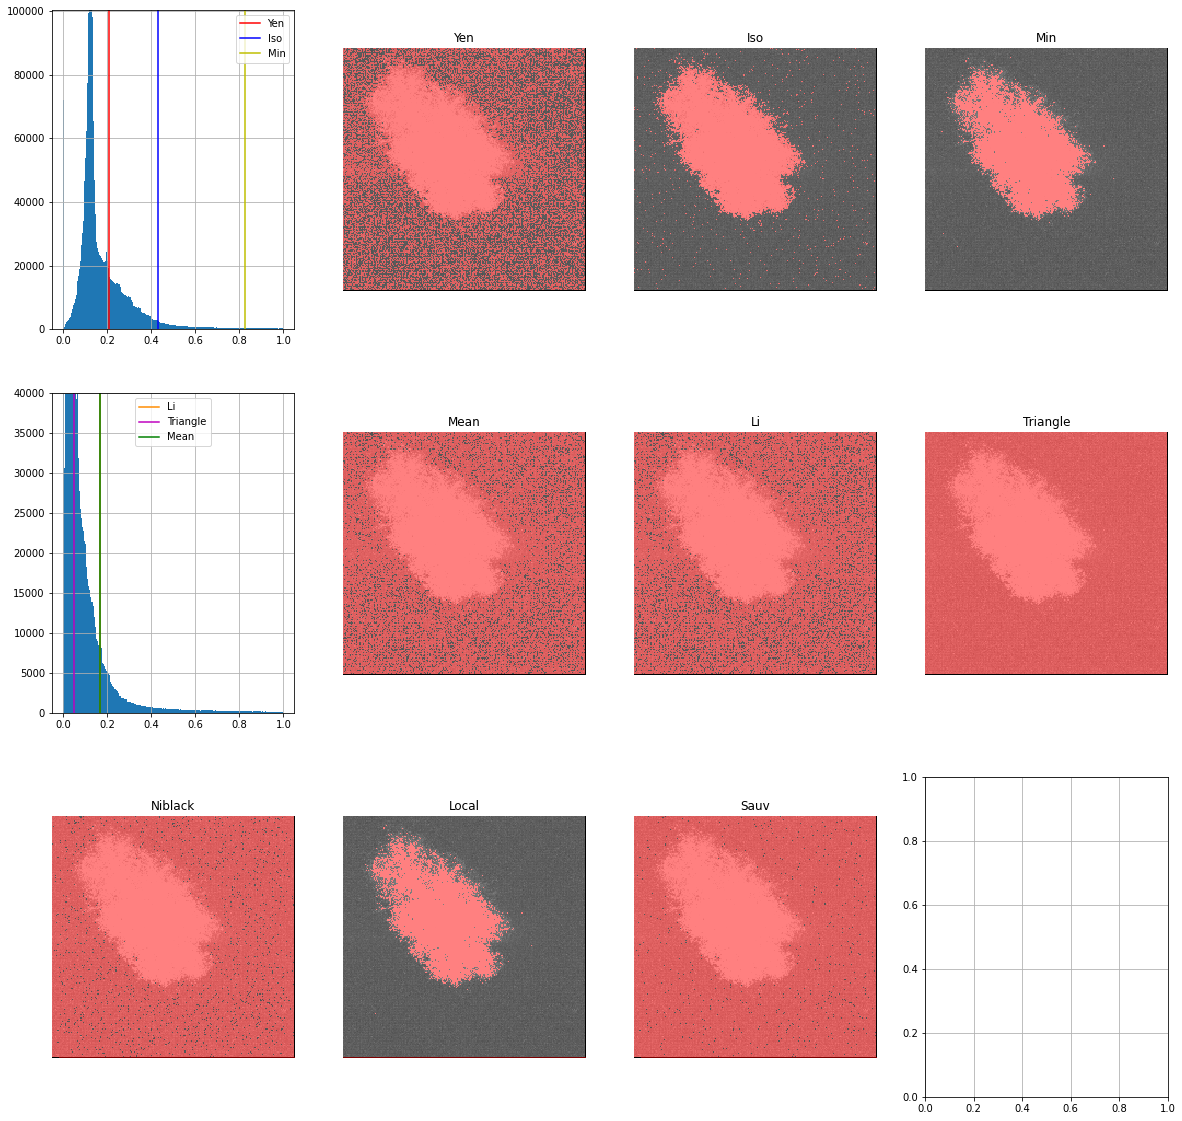

In [50]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(20,20))


## Histogram
ax[0][0].hist(gamma_image_06.ravel(), bins=256)
ax[0][0].axvline(yen_thresh, color='r', label='Yen')
ax[0][0].axvline(iso_thresh, color='b', label='Iso')
ax[0][0].axvline(min_thresh, color='y', label='Min')
ax[0][0].legend()
ax[0][0].set_ylim(0, 10**5+500)

## Yen
ax[0][1].imshow(correction_image)
ax[0][1].imshow((gamma_image_1>=yen_thresh).max(0), cmap=cmap1, alpha=0.5)
ax[0][1].set_title('Yen')
ax[0][1].axis('off')

## Iso
ax[0][2].imshow(correction_image)
ax[0][2].imshow((gamma_image_1>=iso_thresh).max(0), cmap=cmap1, alpha=0.5)
ax[0][2].set_title('Iso')
ax[0][2].axis('off')

## Min
ax[0][3].imshow(correction_image)
ax[0][3].imshow((gamma_image_1>=min_thresh).max(0), cmap=cmap1, alpha=0.5)
ax[0][3].set_title('Min')
ax[0][3].axis('off')


## Histogram
ax[1][0].hist(gamma_image_1.ravel(), bins=256)
ax[1][0].axvline(li_thresh, color='darkorange', label='Li')
ax[1][0].axvline(tri_thresh, color='m', label='Triangle')
ax[1][0].axvline(mean_thresh, color='g', label='Mean')
ax[1][0].legend()
ax[1][0].set_ylim(0, 4*10**4)

## Mean
ax[1][1].imshow(correction_image)
ax[1][1].imshow((gamma_image_1>=mean_thresh).max(0), cmap=cmap1, alpha=0.5)
ax[1][1].set_title('Mean')
ax[1][1].axis('off')

## Li
ax[1][2].imshow(correction_image)
ax[1][2].imshow((thresh_image>li_thresh).max(0), cmap=cmap1, alpha=0.5)
ax[1][2].set_title('Li')
ax[1][2].axis('off')

## Triangle
ax[1][3].imshow(correction_image)
ax[1][3].imshow((gamma_image_1>=tri_thresh).max(0), cmap=cmap1, alpha=0.5)
ax[1][3].set_title('Triangle')
ax[1][3].axis('off')




## Sauv
ax[2][2].imshow(correction_image)
ax[2][2].imshow((gamma_image_1>=sauv_thresh.reshape(IMG_SHAPE)).max(0), cmap=cmap1, alpha=0.5)
ax[2][2].set_title('Sauv')
ax[2][2].axis('off')

## Niblack
ax[2][0].imshow(correction_image)
ax[2][0].imshow((gamma_image_1>=nib_thresh.reshape(IMG_SHAPE)).max(0), cmap=cmap1, alpha=0.5)
ax[2][0].set_title('Niblack')
ax[2][0].axis('off')

## Local
ax[2][1].imshow(correction_image)
ax[2][1].imshow((gamma_image_1>=local_thresh.reshape(IMG_SHAPE)).max(0), cmap=cmap1, alpha=0.5)
ax[2][1].set_title('Local')
ax[2][1].axis('off')

plt.show()

Лучше всего показывают себя Ли и среднее 

### Удаление одиночных пикселей

In [29]:
from skimage.morphology import remove_small_objects

In [30]:
clearest_img = remove_small_objects(gamma_image_1>=li_thresh, 5, connectivity=3)

In [31]:
final_image = np.where(clearest_img, li_img, 0)

In [29]:
# show_napari(final_image, name='final')

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(33.0, 114.5, 114.5), zoom=3.0028260869565218, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=3, last_used=0, range=((0.0, 67.0, 1.0), (0.0, 230.0, 1.0), (0.0, 230.0, 1.0)), current_step=(33, 115, 115), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'final' at 0x7fc7fd3841c0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ]), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, sho

### Определение нескольких астроцитов

In [32]:
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd

In [33]:
image = final_image > 0

In [34]:
label_im = label(image)
regions = regionprops(label_im)

In [35]:
# show_napari(label_im, name='label')

In [36]:
properties = ['area', 'bbox_area']
df = pd.DataFrame(regionprops_table(label_im, final_image, 
             properties=properties))
maximum = df['area'].max()

In [37]:
df.sort_values('area').tail()

,area,bbox_area
226,48,504
154,54,700
222,59,450
239,98,480
0,279261,2797326


In [38]:
masks = []
bbox = []
list_of_index = []
for num, x in enumerate(regions):
    area = x.area
    if area == maximum or area/maximum > 0.6:  
        list_of_index.append(num)
        bbox.append(regions[num].bbox)
count = len(masks)

In [39]:
c = bbox[0]

In [40]:
# show_napari(final_image[c[0]:c[3], c[1]:c[4], c[2]:c[5]], name='smth')

In [41]:
cropped_image = final_image[c[0]:c[3], c[1]:c[4], c[2]:c[5]]

## Общий анализ

In [42]:
def clear_image(image):
    thresh = threshold_li(image)
    binary = image >= thresh
    without_binary = remove_small_objects(binary, 3, connectivity=3)
    filtered_image = np.where(without_binary, image, 0)
    return filtered_image

In [43]:
def crop_image(image):
    a = image.nonzero()
    start = np.min(a[0])
    end = np.max(a[0]+1)
    start_in = np.min(a[1])
    end_in = np.max(a[1]+1)
    start_inn = np.min(a[2])
    end_inn = np.max(a[2]+1)
    return image[start:end, start_in:end_in, start_inn:end_inn]

In [44]:
def separate_images(image):
    bin_image = image > 0
    label_im = label(bin_image)
    regions = regionprops(label_im)
    
    properties = ['area', 'bbox_area']
    df = pd.DataFrame(regionprops_table(label_im, image, 
                 properties=properties))
    maximum = df['area'].max()

    bbox = []
    for num, x in enumerate(regions):
        area = x.area
        if area == maximum or area/maximum > 0.6:  
            bbox.append(regions[num].bbox)
      
    images = []
    for i, c in enumerate(bbox):
        images.append((image[c[0]:c[3], c[1]:c[4], c[2]:c[5]], '_{}'.format(i)))
    return images

## Hessian vectors

In [45]:
import numpy as np

In [55]:
def add_hessian_vectors(viewer, vectors, lengths, axis=0, index=1):
    Vfx = vectors[..., axis][..., ::-1]

    V = Vfx[...,0] # row directions (Y)
    U = Vfx[...,1] # col directions (X)
    C = Vfx[...,2]

    nr, nc, nd = (1, U.shape[0]) if U.ndim == 1 else U.shape
    indexgrid = np.meshgrid(np.arange(nc), np.arange(nr), np.arange(nd))
    x, y, z = [np.ravel(a)[::index] for a in indexgrid]

    u = U.ravel()[::index]
    v = V.ravel()[::index]
    c = C.ravel()[::index]
    length = lengths.ravel()[::index]

    x1, y1, z1 = u*length, v*length, c*length

    vectors = np.zeros((u.shape[0], 2, 3))
    vectors[...,0, 0] = y
    vectors[...,0, 1] = x
    vectors[...,0, 2] = z
    vectors[...,1, 0] = y1
    vectors[...,1, 1] = x1
    vectors[...,1, 2] = z1

    properties = {'length': length}

    viewer.add_vectors(vectors, edge_width=0.1,
                       length=1,  properties=properties,
                       edge_color='length', edge_colormap='inferno')
    return viewer


Применяем фильтр Сато для обнаружения волокон

In [47]:
%time data_sato, Vf = hcecp.sato3d(cropped_image, 1, return_vectors=True)
# show_napari(data_sato, name='data_sato')

CPU times: user 3.9 s, sys: 100 ms, total: 4 s
Wall time: 4.1 s


In [48]:
Vf.shape

(63, 298, 149, 3, 3)

###  Предобработка изображений

Сглаживание?

In [49]:
%time stackz_sato = hcecp.percentile_rescale(data_sato)
# show_napari(stackz_sato, name='stackz_sato')

CPU times: user 27.8 ms, sys: 0 ns, total: 27.8 ms
Wall time: 27.5 ms


In [50]:
weights = stackz_sato**0.5

In [57]:
viewer = napari.view_image(cropped_image)
add_hessian_vectors(viewer, Vf, weights, index=5)
napari.run()

## Principal Axes

In [19]:
from numba import jit
from pathlib import Path
import itertools as itt


In [20]:
import ucats
from imfun.filt import l1spline, l2spline

In [21]:
%gui qt

In [22]:
style.use('seaborn-muted')
rc("image",cmap='gray',aspect='equal',interpolation='nearest')
rc("figure", figsize=(13,8))
rc('axes', labelsize=16)

In [23]:
@jit
def probabilistic_sample(data, weights, Npoints=-1):
    sh = data.shape
    Npoints = len(data) if Npoints < 0 else Npoints
    done = False
    i = 0
    out = np.zeros((Npoints, sh[1]))
    while i < Npoints:
        for k in range(len(data)):
            point = data[k]
            if np.random.rand() < weights[k]:
                out[i] = point
                i+=1
                if i >= Npoints:
                    break
    return out

def percentile_rescale(arr, plow=1, phigh=99.5):
    low, high = np.percentile(arr, (plow, phigh))
    if low == high:
        return np.zeros_like(arr)
    else:
        return np.clip((arr-low)/(high-low), 0, 1)

### Example

In [484]:
zstack = cropped_image

In [485]:
%time X = np.array(list(itt.product(*map(range, zstack.shape)))) # N-dimensional, but slower

CPU times: user 2.2 s, sys: 221 ms, total: 2.42 s
Wall time: 2.4 s


In [486]:
X

array([[  0,   0,   0],
       [  0,   0,   1],
       [  0,   0,   2],
       ...,
       [ 55, 349, 172],
       [ 55, 349, 173],
       [ 55, 349, 174]])

In [487]:
gamma = 1
weights = percentile_rescale(np.ravel(zstack)**gamma)
weights_s = percentile_rescale(np.ravel(ndi.gaussian_filter(zstack,5))**2,plow=99.5,phigh=99.99)

In [488]:
center = np.sum(X*weights_s[:,None],axis=0)/np.sum(weights_s)
center

array([ 28.20774572, 163.68117347,  91.44237488])

In [489]:
Xc = X-center

In [490]:
multiplicity=3

%time Xp = probabilistic_sample(Xc, weights, multiplicity*len(X))
%time u,s,vh = np.linalg.svd(Xp,full_matrices=False)
u,vh = ucats.decomposition.svd_flip_signs(u,vh, mode='u')
s /= np.sqrt(len(u)-1) # normalize by number of points

CPU times: user 8.57 s, sys: 113 ms, total: 8.68 s
Wall time: 8.63 s
CPU times: user 2.6 s, sys: 2.06 s, total: 4.67 s
Wall time: 1.13 s


In [491]:
vh

array([[ 0.04567958,  0.99798244, -0.04409562],
       [ 0.05934399,  0.04135274,  0.99738069],
       [-0.99719189,  0.04817674,  0.05733528]])

In [492]:
# x = array([[(0,0,0), vh[0]]])
# x.shape

In [493]:
x = np.array([[center,vh[k]*2*s[k]] for k in range(3)])
x

array([[[ 28.20774572, 163.68117347,  91.44237488],
        [  4.99201903, 109.06289845,  -4.8189182 ]],

       [[ 28.20774572, 163.68117347,  91.44237488],
        [  3.27557714,   2.2825243 ,  55.05187015]],

       [[ 28.20774572, 163.68117347,  91.44237488],
        [-16.37467101,   0.79109976,   0.94149015]]])

In [494]:
napari_scale = (0.38, 0.2, 0.2)

In [495]:
w = napari.view_image(zstack, ndisplay=3, scale=napari_scale)
w.add_image(weights_s.reshape(zstack.shape), colormap='cyan',blending='additive',scale=napari_scale)
w.add_vectors(x, edge_width=3, edge_color_cycle=['red','magenta', 'blue'],scale=napari_scale)

<Vectors layer 'x' at 0x7f32499661f0>

In [496]:
Y = Xc@vh.T#@np.diag(1/s)

In [497]:
zstack_r = np.ravel(zstack)

In [498]:
np.amin(zstack_r, where=zstack_r>0, initial=1)

0.05613072758269141

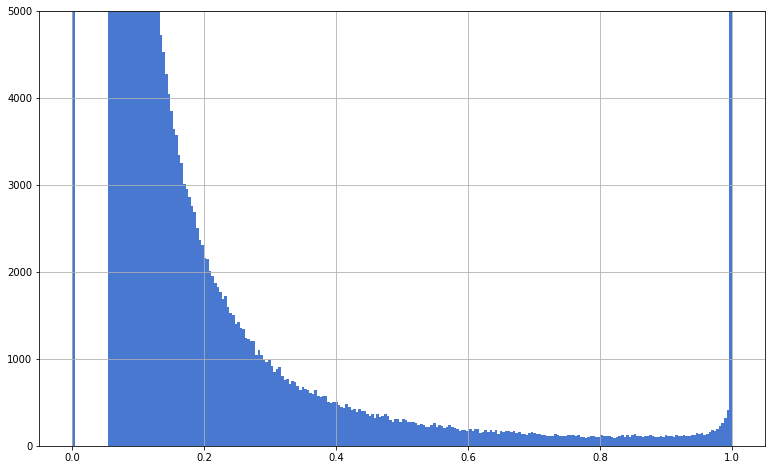

In [499]:
plt.hist(zstack_r, bins=256)
plt.ylim(0, 5000)
plt.show()

In [500]:
Y.shape


(3430000, 3)

In [501]:
zstack_r.shape

(3430000,)

In [502]:
Yx1 = Y[:,0][zstack_r>0]
Yx2 = Y[:,1][zstack_r>0]
Yx3 = Y[:,2][zstack_r>0]
Wx = zstack_r[zstack_r>0]

In [503]:
xq = arange(-150,250, 5)

Text(0.5, 1.0, 'Brightness distribution along first principal axis')

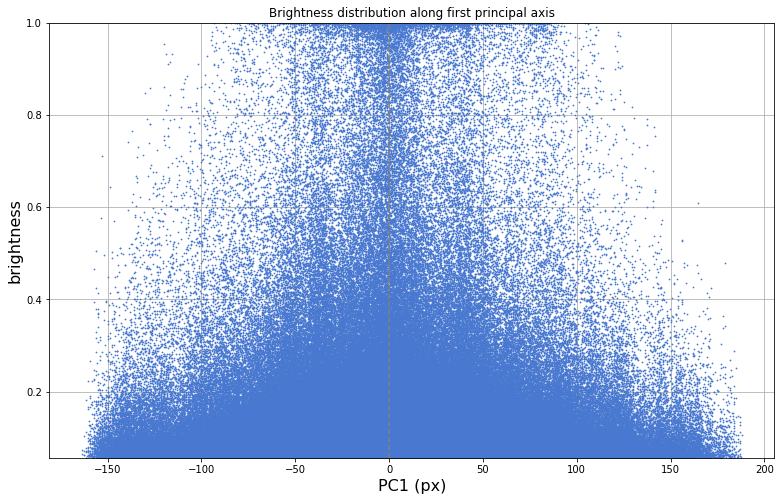

In [512]:
figure()
# plot(Y[:,0],np.ravel(zstack),'.', alpha=0.01)
# hexbin(Y[:,0], zstack_r, mincnt=5, cmap='plasma', bins='log')
plot(Yx1, Wx, '.', alpha=1, markersize=1.5)
# xlim(-150, 150)
ylim(np.amin(zstack_r, where=zstack_r>0, initial=1), 1)
ylabel('brightness')
xlabel('PC1 (px)')
axvline(0, color='gray', ls='--')

# plot(xq+2.5, yq2, lw=2)
# plot(xq2, yq, lw=2)

title('Brightness distribution along first principal axis')

# gcf()

In [505]:
compactness(Yx1, Wx)

0.816604654812076

Text(0.5, 1.0, 'Brightness distribution along second principal axis')

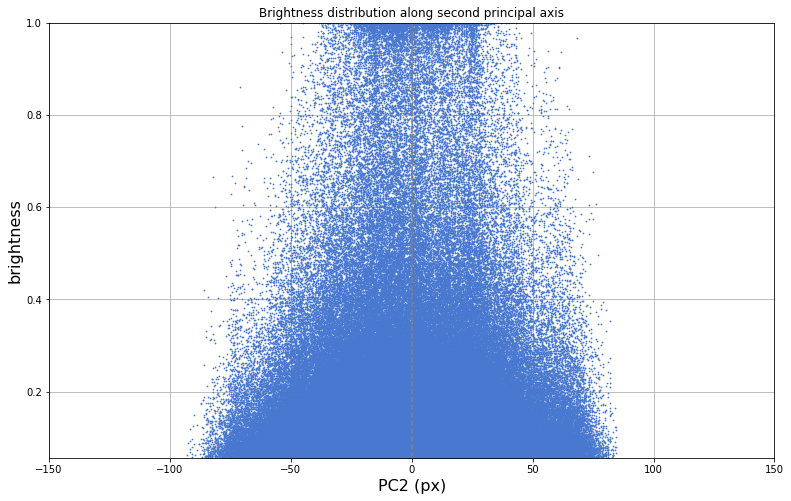

In [506]:
figure()
# plot(Y[:,0],np.ravel(zstack),'.', alpha=0.01)
# hexbin(Y[:,1], zstack_r, mincnt=5, cmap='plasma',bins='log')
plot(Yx2, Wx, '.', alpha=1, markersize=1.5)
xlim(-150,150)
ylim(np.amin(zstack_r, where=zstack_r>0, initial=1), 1)
ylabel('brightness')
xlabel('PC2 (px)')
axvline(0, color='gray',ls='--')
title('Brightness distribution along second principal axis')

Text(0.5, 1.0, 'Brightness distribution along third principal axis')

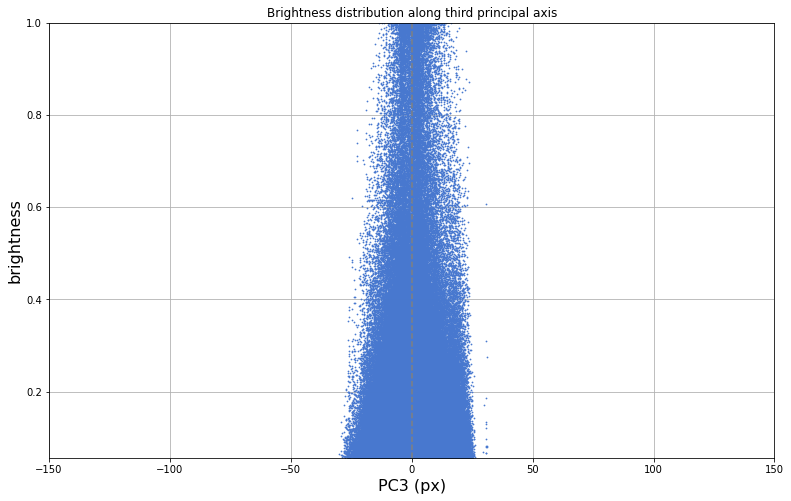

In [507]:
figure()
# hexbin(Y[:,2], zstack_r, mincnt=5, cmap='plasma',bins='log')
plot(Yx3, Wx, '.', markersize=1.5)
xlim(-150,150)
ylim(np.amin(zstack_r, where=zstack_r>0, initial=1), 1)
ylabel('brightness')
xlabel('PC3 (px)')
axvline(0, color='gray',ls='--')
title('Brightness distribution along third principal axis')

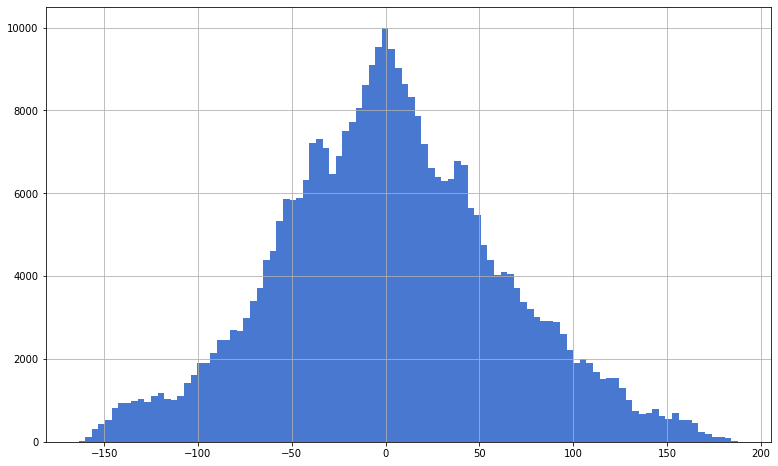

In [508]:
plt.hist(Yx1, bins=100)
plt.show()

/home/incredible/Neuroscience/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


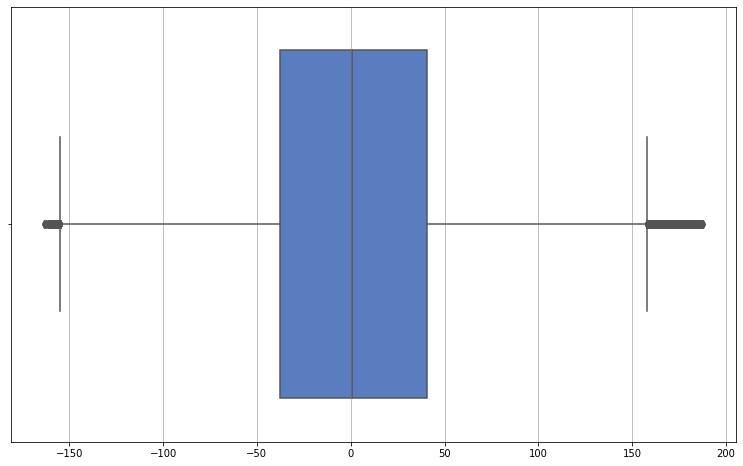

In [509]:
sns.boxplot(Yx1)

In [510]:
Yx1, Wx

(array([-107.35430527, -105.40243601, -104.40445357, ...,  -18.24959625,
         -17.20751819,   61.2316795 ]),
 array([0.07632203, 0.14271513, 0.18339635, ..., 0.07003437, 0.06231093,
        0.0647845 ]))

In [511]:
Yx1[Wx < .5 + 10e-5][Wx[Wx < .5+10e-5] > .5-10e-5]

array([  21.49559905, -142.92985972,   16.86656888,  -82.13637017,
        -43.97317466,   -4.02599814,   29.16191794,  -11.02036944,
         -2.84846531,  -30.58612835,  -45.8188547 ,   30.91130711,
          3.57050462,   57.06469588,  -72.27457694,  -40.02888555,
         32.10664065,  -37.1082994 ,   13.11038243,    2.92491   ,
         -8.63305012])

### Расчеты

In [24]:
anisotropy = lambda s: s[0]/np.sum(s[:2])

In [25]:
asymmetry = lambda y: np.sum(y[y>0])/np.sum(y[y<0])

In [26]:
def compactness(Yx, Wx):
    half_width = Yx[Wx < 0.5 + 10e-4][Wx[Wx < .5+10e-4] > .5-10e-4]
    fwhm = half_width.max() - half_width.min()
    width = Yx.max() - Yx.min()
    return fwhm/width

In [27]:
def principal_axes(zstack):
    X = np.array(list(itt.product(*map(range, zstack.shape)))) # N-dimensional, but slower
    gamma = 1
    weights = percentile_rescale(np.ravel(zstack)**gamma)
    weights_s = percentile_rescale(np.ravel(ndi.gaussian_filter(zstack,5))**2,plow=99.5,phigh=99.99)
    center = np.sum(X*weights_s[:,None],axis=0)/np.sum(weights_s)
    Xc = X-center
    
    multiplicity=3

    Xp = probabilistic_sample(Xc, weights, multiplicity*len(X))
    u,s,vh = np.linalg.svd(Xp, full_matrices=False)
    u,vh = ucats.decomposition.svd_flip_signs(u, vh, mode='u')
    
    Y = Xc@vh.T
    vectors = np.array([[center,vh[k]*2*s[k]] for k in range(3)])
    s /= np.sqrt(len(u)-1) # normalize by number of points
    
    zstack_r = np.ravel(zstack)
    Yx1 = Y[:, 0][zstack_r > 0]
    Wx = zstack_r[zstack_r > 0]
    return anisotropy(s), asymmetry(Y), compactness(Yx1, Wx), center, vectors

In [20]:
anis = np.load('anis.npy', allow_pickle=True).item()

In [275]:
anis = {}
for i, name in enumerate(names):
    print(i, name)
    if i == 18:
        continue
    if name in anis.keys():
        continue
        
#     if 'both' in name:
#         continue
    
    stack, meta = ccdb.read_pic(name)
    dims = ccdb.get_axes(meta)
    if len(dims):
        zoom = dims[0][0]/dims[-1][0]
    else:
        zoom = 4
    image = ndi.zoom(stack.astype(float),(1, zoom,zoom))
    image = hcecp.percentile_rescale(image)
    zstack = clear_image(image)
#     zstack = crop_image(zstack)
    images = separate_images(zstack)
    
    for image, sub in images:
        %time anis['{}{}'.format(name, sub)] = list(principal_axes(image))
        close('all')
    
    np.save('anis_sep', anis)        

0 /home/incredible/Neuroscience/selected-for-complexity/data/1wk-both1-grn-raw.pic
CPU times: user 2.71 s, sys: 713 ms, total: 3.42 s
Wall time: 2 s
1 /home/incredible/Neuroscience/selected-for-complexity/data/1wk-both1-red-raw.pic
CPU times: user 6.42 s, sys: 1.3 s, total: 7.73 s
Wall time: 5.36 s
2 /home/incredible/Neuroscience/selected-for-complexity/data/1wk-both4-grn-raw.pic
CPU times: user 6.79 s, sys: 1.46 s, total: 8.26 s
Wall time: 5.69 s
3 /home/incredible/Neuroscience/selected-for-complexity/data/1wk-both4-red-raw.pic
CPU times: user 4.75 s, sys: 1.11 s, total: 5.86 s
Wall time: 3.87 s
4 /home/incredible/Neuroscience/selected-for-complexity/data/1wk-both5-grn-raw.pic
CPU times: user 5.46 s, sys: 1.19 s, total: 6.65 s
Wall time: 4.43 s
CPU times: user 7.09 s, sys: 1.63 s, total: 8.72 s
Wall time: 5.62 s
5 /home/incredible/Neuroscience/selected-for-complexity/data/1wk-both5-red-raw.pic
CPU times: user 6.92 s, sys: 1.56 s, total: 8.48 s
Wall time: 5.75 s
6 /home/incredible/Neur

CPU times: user 13.6 s, sys: 2.77 s, total: 16.4 s
Wall time: 11.6 s
56 /home/incredible/Neuroscience/selected-for-complexity/data/4wk-both5-grn-raw.pic
CPU times: user 25.9 s, sys: 3.67 s, total: 29.5 s
Wall time: 23.4 s
57 /home/incredible/Neuroscience/selected-for-complexity/data/4wk-both6-red-raw.pic
CPU times: user 1min 51s, sys: 58.1 s, total: 2min 49s
Wall time: 3min 20s
58 /home/incredible/Neuroscience/selected-for-complexity/data/4wk-both7-grn-raw.pic
CPU times: user 17.5 s, sys: 3.79 s, total: 21.3 s
Wall time: 36.7 s
59 /home/incredible/Neuroscience/selected-for-complexity/data/4wk-both7-red-raw.pic
CPU times: user 26.1 s, sys: 4.42 s, total: 30.6 s
Wall time: 23 s
60 /home/incredible/Neuroscience/selected-for-complexity/data/4wk-both8-grn-raw.pic
CPU times: user 10.1 s, sys: 2.41 s, total: 12.5 s
Wall time: 8.35 s
61 /home/incredible/Neuroscience/selected-for-complexity/data/4wk-both8-red-raw.pic
CPU times: user 13.1 s, sys: 2.86 s, total: 15.9 s
Wall time: 10.9 s
62 /home/

In [112]:
anis['/home/incredible/Neuroscience/selected-for-complexity/data/1wk-ly14-grn-raw.pic']

[0.6205374376858254,
 -1.4755617428364858,
 0.5229197976553162,
 array([ 20.68746502,  93.38241747, 108.88811835]),
 array([[[ 2.06874650e+01,  9.33824175e+01,  1.08888118e+02],
         [-3.69903904e+03, -1.00299776e+05, -7.04894128e+04]],
 
        [[ 2.06874650e+01,  9.33824175e+01,  1.08888118e+02],
         [-8.19092704e+03,  4.30683596e+04, -6.08523764e+04]],
 
        [[ 2.06874650e+01,  9.33824175e+01,  1.08888118e+02],
         [-2.15039402e+04, -8.28874882e+02,  2.30786261e+03]]])]

### Soma segmentation, Center

In [ ]:
X = np.array(list(itt.product(*map(range, zstack.shape))))
weights_s = percentile_rescale(np.ravel(ndi.gaussian_filter(zstack,5))**2,plow=99.5,phigh=99.99)
soma = weights_s.reshape(zstack.shape)
center = np.sum(X*weights_s[:,None],axis=0)/np.sum(weights_s)

In [427]:
a = soma.nonzero()
start = np.min(a[0])
end = np.max(a[0]+1)
start_in = np.min(a[1])
end_in = np.max(a[1]+1)
start_inn = np.min(a[2])
end_inn = np.max(a[2]+1)

In [429]:
crop_arr = soma[start:end, start_in:end_in, start_inn:end_inn]

In [430]:
a = zstack.nonzero()
start = np.min(a[0])
end = np.max(a[0]+1)
start_in = np.min(a[1])
end_in = np.max(a[1]+1)
start_inn = np.min(a[2])
end_inn = np.max(a[2]+1)

In [431]:
domain = zstack[start:end, start_in:end_in, start_inn:end_inn]

In [432]:
show_napari(domain, name='domain')

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(19.5, 126.0, 126.0), zoom=2.9776679841897233, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=3, last_used=2, range=((0.0, 40.0, 1.0), (0.0, 253.0, 1.0), (0.0, 253.0, 1.0)), current_step=(0, 0, 0), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'domain' at 0x7fe2328d42b0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ]), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), help='', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mous

# Анализ полученных данных

In [28]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from statannotations.Annotator import Annotator

In [29]:
anis = np.load('anis_sep.npy', allow_pickle=True).item()

In [30]:
data = pd.DataFrame.from_dict(anis, orient='index', columns=['anisotropy', 'asymmetry', 'compactness', 'center', 'vectors'])

In [31]:
data.reset_index(inplace=True)

In [32]:
def get_week(filename):
    base_name = os.path.basename(filename)
    week = base_name[0]
    return week

In [33]:
data['week'] = data['index'].apply(get_week)
data['index'] = data['index'].apply(os.path.basename)
data['asymmetry'] = data['asymmetry'].apply(np.abs)

In [34]:
data_ly = data

In [35]:
# data_ly = data[data['index'].apply(lambda x: 'ly' in x)]

In [70]:
data_ly = data_ly.drop(12)

In [71]:
data_ly.loc[0:60]

,index,anisotropy,asymmetry,compactness,center,vectors,week
0,1wk-both1-grn-raw.pic_0,0.595984,0.955609,0.557618,"[16.623676184851305, 58.22468851210012, 55.512...","[[[16.623676184851305, 58.22468851210012, 55.5...",1
1,1wk-both1-red-raw.pic_0,0.576805,1.050049,0.416645,"[15.86335046135281, 89.82938868749008, 88.0655...","[[[15.86335046135281, 89.82938868749008, 88.06...",1
2,1wk-both4-grn-raw.pic_0,0.571012,1.262460,0.861828,"[21.090765497919946, 90.14778484597522, 67.779...","[[[21.090765497919946, 90.14778484597522, 67.7...",1
3,1wk-both4-red-raw.pic_0,0.572001,0.912050,0.414594,"[14.927892078132821, 85.41249774552503, 78.814...","[[[14.927892078132821, 85.41249774552503, 78.8...",1
5,1wk-both5-grn-raw.pic_1,0.582860,1.601609,0.710995,"[23.06711438052889, 96.52957477661732, 60.4507...","[[[23.06711438052889, 96.52957477661732, 60.45...",1
6,1wk-both5-red-raw.pic_0,0.600540,1.366246,0.720775,"[21.103966811925236, 78.9733501149981, 92.0651...","[[[21.103966811925236, 78.9733501149981, 92.06...",1
7,1wk-both7-grn-raw.pic_0,0.579859,1.076575,0.803558,"[23.9142701631357, 110.29439475135112, 74.9232...","[[[23.9142701631357, 110.29439475135112, 74.92...",1
8,1wk-both7-red-raw.pic_0,0.550922,1.705230,0.645799,"[16.215254724403383, 100.66507257825906, 100.3...","[[[16.215254724403383, 100.66507257825906, 100...",1
9,1wk-both8-grn-raw.pic_0,0.622259,2.075852,0.925667,"[16.873728282974042, 92.72112512735173, 58.171...","[[[16.873728282974042, 92.72112512735173, 58.1...",1
10,1wk-both8-red-raw.pic_0,0.533191,0.962790,0.392863,"[14.335285602883664, 67.94302409137946, 71.315...","[[[14.335285602883664, 67.94302409137946, 71.3...",1


In [72]:
x = 'week'
y = 'anisotropy'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 3: Kruskal-Wallis paired samples, P_val:1.619e-01 Stat=1.956e+00
3 vs. 4: Kruskal-Wallis paired samples, P_val:9.039e-03 Stat=6.815e+00
1 vs. 4: Kruskal-Wallis paired samples, P_val:1.935e-04 Stat=1.389e+01


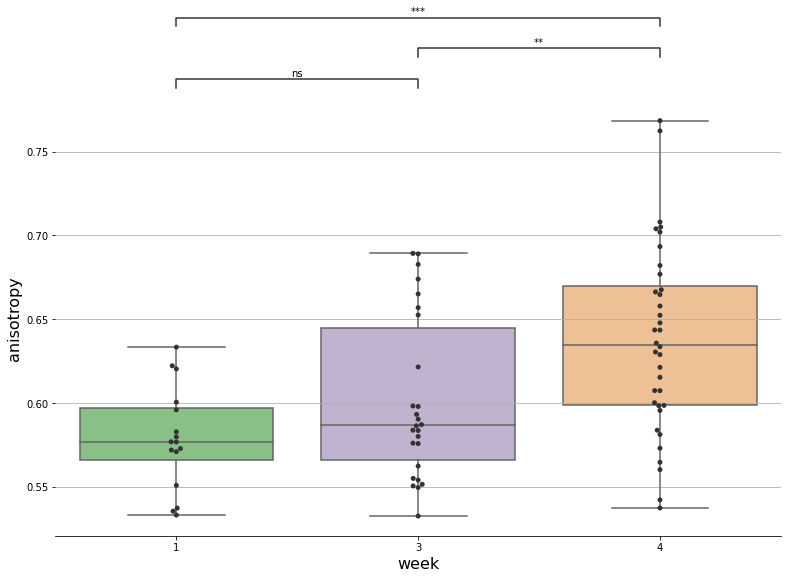

In [73]:
ax = sns.boxplot(data=data_ly, x=x, y=y, palette="Accent")
sns.swarmplot(data=data_ly, x=x, y=y, color=".2")

annotator = Annotator(ax, x=x, y=y, pairs=[("1", "3"), ("3", "4"), ("1", "4")], data=data_ly)
annotator.configure(test='Kruskal', text_format='star', loc='outside')
annotator.apply_and_annotate()
sns.despine(left=True)

In [74]:
y = 'asymmetry'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 3: Kruskal-Wallis paired samples, P_val:1.491e-02 Stat=5.928e+00
3 vs. 4: Kruskal-Wallis paired samples, P_val:8.641e-01 Stat=2.930e-02
1 vs. 4: Kruskal-Wallis paired samples, P_val:2.036e-02 Stat=5.381e+00


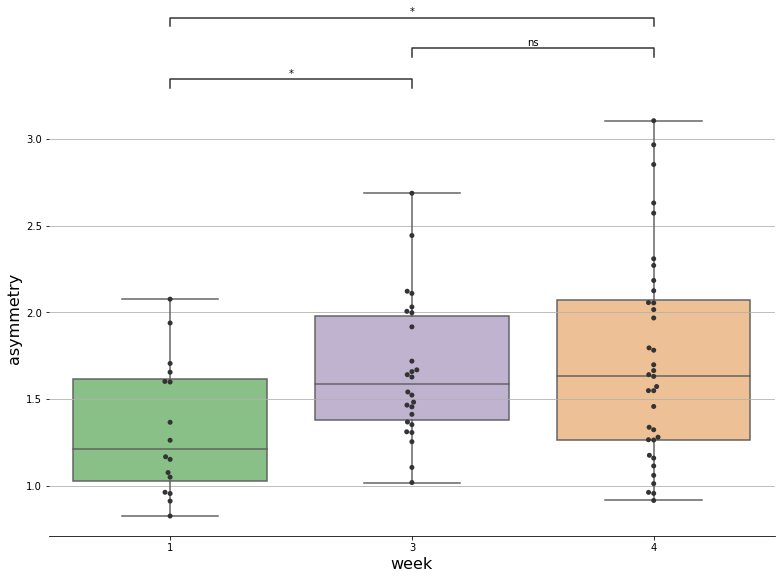

In [75]:
ax = sns.boxplot(data=data_ly, x=x, y=y, palette="Accent")
sns.swarmplot(data=data_ly, x=x, y=y, color=".2")

annotator = Annotator(ax, x=x, y=y, pairs=[("1", "3"), ("3", "4"), ("1", "4")], data=data_ly)
annotator.configure(test='Kruskal', text_format='star', loc='outside')
annotator.apply_and_annotate()
sns.despine(left=True)

In [76]:
y = 'compactness'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 3: Kruskal-Wallis paired samples, P_val:6.597e-01 Stat=1.939e-01
3 vs. 4: Kruskal-Wallis paired samples, P_val:2.738e-03 Stat=8.974e+00
1 vs. 4: Kruskal-Wallis paired samples, P_val:2.116e-01 Stat=1.560e+00


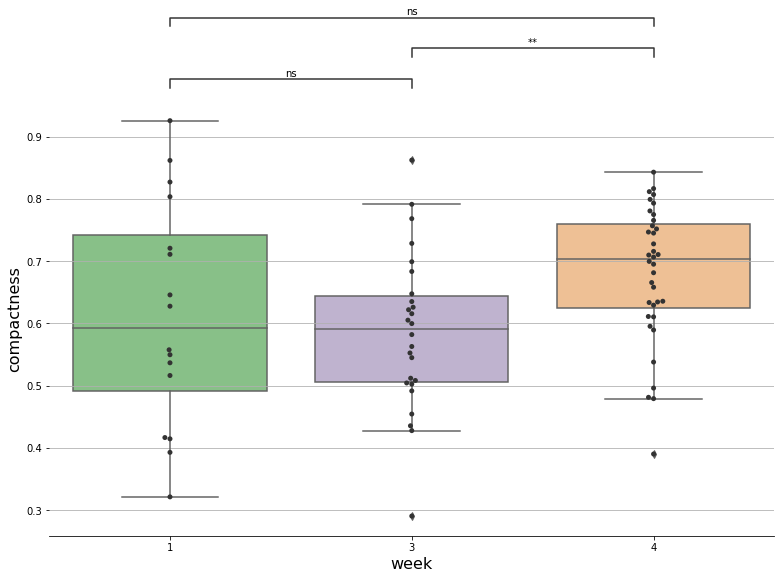

In [77]:
ax = sns.boxplot(data=data_ly, x=x, y=y, palette="Accent")
sns.swarmplot(data=data_ly, x=x, y=y, color=".2")
annotator = Annotator(ax, x=x, y=y, pairs=[("1", "3"), ("3", "4"), ("1", "4")], data=data_ly)
annotator.configure(test='Kruskal', text_format='star', loc='outside')
annotator.apply_and_annotate()
sns.despine(left=True)

# Статистика

In [38]:
from scipy.stats import kruskal

In [39]:
data_1 = data_ly.query('week == 1')['anisotropy']
data_3 = data_ly.query('week == 3')['anisotropy']
data_4 = data_ly.query('week == 4')['anisotropy']

In [40]:
kruskal(data_1, data_3, data_4)

KruskalResult(statistic=7.111607142857139, pvalue=0.028558416965421322)

In [41]:
kruskal(data_1, data_3)

KruskalResult(statistic=0.05410379094591633, pvalue=0.8160703062919263)

In [42]:
kruskal(data_1, data_4)

KruskalResult(statistic=2.5439823334560288, pvalue=0.11071522677730539)

In [43]:
kruskal(data_3, data_4)

KruskalResult(statistic=6.849056603773562, pvalue=0.008868809114679032)

In [407]:
data_1 = data_ly.query('week == "1"')
data_3 = data_ly.query('week == "3"')
data_4 = data_ly.query('week == "4"')

In [513]:
data_3

,index,anisotropy,asymmetry,compactness,center,vectors,week
22,3wk-both1-grn-raw.pic_0,0.656958,1.916080,0.683451,"[21.18354396230113, 90.88182058485489, 77.8325...","[[[21.18354396230113, 90.88182058485489, 77.83...",3
23,3wk-both1-red-raw.pic_0,0.665084,2.442560,0.290573,"[21.913141958720743, 30.310591172623884, 57.15...","[[[21.913141958720743, 30.310591172623884, 57....",3
24,3wk-both2-grn-raw.pic_0,0.593260,1.626980,0.491613,"[40.7820878662755, 102.56997765513277, 110.820...","[[[40.7820878662755, 102.56997765513277, 110.8...",3
25,3wk-both2-red-raw.pic_0,0.532639,1.540970,0.454427,"[36.498459481613565, 81.55384612640196, 109.08...","[[[36.498459481613565, 81.55384612640196, 109....",3
26,3wk-ly10-raw.pic_0,0.682735,1.307259,0.699149,"[31.107958626177727, 100.70475218158602, 64.03...","[[[31.107958626177727, 100.70475218158602, 64....",3
27,3wk-ly11-raw.pic_0,0.689008,2.686296,0.862316,"[39.672404185506146, 67.45554622553927, 69.316...","[[[39.672404185506146, 67.45554622553927, 69.3...",3
28,3wk-ly12-raw.pic_0,0.575870,1.106087,0.621976,"[35.17374313764207, 108.16261072214395, 73.251...","[[[35.17374313764207, 108.16261072214395, 73.2...",3
29,3wk-ly13-raw.pic_0,0.689298,2.108853,0.582058,"[35.346377307669925, 159.0463167272296, 65.190...","[[[35.346377307669925, 159.0463167272296, 65.1...",3
30,3wk-ly14-raw.pic_0,0.621589,1.254170,0.647575,"[31.078592362446965, 96.17607951521792, 89.855...","[[[31.078592362446965, 96.17607951521792, 89.8...",3
31,3wk-ly15-raw.pic_0,0.576112,1.668215,0.502491,"[34.679833969192266, 78.0830059773646, 101.619...","[[[34.679833969192266, 78.0830059773646, 101.6...",3


In [45]:
kruskal(data_1, data_3, data_4)

KruskalResult(statistic=0.08395770895771193, pvalue=0.9588900565880767)

In [46]:
kruskal(data_1, data_3)

KruskalResult(statistic=0.05410379094591633, pvalue=0.8160703062919263)

In [47]:
kruskal(data_1, data_4)

KruskalResult(statistic=0.0894368789105755, pvalue=0.7648942716993864)

In [48]:
kruskal(data_3, data_4)

KruskalResult(statistic=0.04052696215251217, pvalue=0.8404537639692675)

In [49]:
data_1 = data_ly.query('week == 1')['compactness']
data_3 = data_ly.query('week == 3')['compactness']
data_4 = data_ly.query('week == 4')['compactness']

In [50]:
kruskal(data_1, data_3, data_4)

KruskalResult(statistic=10.405313436563404, pvalue=0.005501927914357912)

In [51]:
kruskal(data_1, data_3)

KruskalResult(statistic=6.891056312108944, pvalue=0.008662806281832415)

In [52]:
kruskal(data_1, data_4)

KruskalResult(statistic=8.943687891056314, pvalue=0.0027843001906912163)

In [53]:
kruskal(data_3, data_4)

KruskalResult(statistic=1.2874846488779497, pvalue=0.25651201577259497)